In [1]:
import requests
from pprint import pprint
from bs4 import BeautifulSoup
from pymongo import MongoClient
import pandas as pd
import pickle
import seaborn as sns

%matplotlib inline
import matplotlib.pyplot as plt

In [168]:
# for the list of occupations
occ_list = requests.get("https://en.wikipedia.org/w/api.php?action=parse&format=json&page=Lists_of_occupations&prop=text")
soup = BeautifulSoup(occ_list.json()['parse']['text']['*'], "lxml")

In [396]:
# get list of occupation subgroups (e.g. theater, science, computer)
occ_subgroups = []
for item in soup.find_all('a'):
    if item["href"][0:7] == '/wiki/L':
        occ_subgroups.append(item["href"][6:])
        print(item["href"])

/wiki/List_of_computer_occupations
/wiki/List_of_scientific_occupations
/wiki/List_of_artistic_occupations
/wiki/List_of_dance_occupations
/wiki/List_of_theatre_personnel
/wiki/List_of_writing_occupations
/wiki/List_of_healthcare_occupations
/wiki/List_of_mental_health_occupations
/wiki/List_of_nursing_specialties
/wiki/List_of_industrial_occupations
/wiki/List_of_metalworking_occupations
/wiki/List_of_railway_industry_occupations
/wiki/List_of_sewing_occupations
/wiki/List_of_corporate_titles


In [403]:
# take out all the nursing specialties and sewing jobs
occ_subgroups = [occ for occ in occ_subgroups if 'nurs' not in occ]
occ_subgroups = [occ for occ in occ_subgroups if 'sewing' not in occ]

In [404]:
occ_subgroups

['List_of_computer_occupations',
 'List_of_scientific_occupations',
 'List_of_artistic_occupations',
 'List_of_dance_occupations',
 'List_of_theatre_personnel',
 'List_of_writing_occupations',
 'List_of_healthcare_occupations',
 'List_of_mental_health_occupations',
 'List_of_industrial_occupations',
 'List_of_metalworking_occupations',
 'List_of_railway_industry_occupations',
 'List_of_corporate_titles']

In [406]:
# pull the list of occupations listed in wikipedia
base_url = "https://en.wikipedia.org/w/api.php?action=parse&format=json&page={}&prop=text"
occ_list = []
for subgroup in occ_subgroups:
    subgroup_url = base_url.format(subgroup)
    response = requests.get(subgroup_url)
    subgroup_soup = BeautifulSoup(response.json()['parse']['text']['*'], "lxml")
    subgroup_jobs = []
    if 'theat' in subgroup:
        div1 = subgroup_soup.find('div', attrs={"role":"note"})
        all_sibs = div1.find_next_siblings()
        uls = [ele for ele in all_sibs if str(ele)[0:4]=='<ul>']
        for ul in uls:
            for item in ul.find_all('a'):
                link = item["href"]
                if link[0:6] == '/wiki/':
                    occ_list.append(item["href"])
                    print(item["href"])
            
    else:
        for item in subgroup_soup.find_all('a'):
            link = item["href"]
            if link[0:6] == '/wiki/' and '<li>' in item.previous.encode('utf-8'):
                print(item["href"])
                occ_list.append(item["href"])

occ_list = list(set(occ_list))

/wiki/Application_analyst
/wiki/Computer_operator
/wiki/Computer_repair_technician
/wiki/Computer_scientist
/wiki/Systems_analyst
/wiki/Data_entry_clerk
/wiki/Database_administrator
/wiki/Data_analyst
/wiki/Data_scientist
/wiki/Network_analyst
/wiki/Network_administrator
/wiki/Programmer
/wiki/Security_engineer
/wiki/Software_design
/wiki/Software_analyst
/wiki/Software_quality_analyst
/wiki/System_Administrator
/wiki/Web_developer
/wiki/Educational_technologist
/wiki/Engineer
/wiki/Engineering_technician
/wiki/Engineering_technologist
/wiki/Computational_scientist
/wiki/Mathematician
/wiki/Demographic_marketer
/wiki/Statistician
/wiki/Gentleman_scientist
/wiki/Government_scientist
/wiki/Healthcare_science
/wiki/Hiwi_(volunteer)
/wiki/Inventor
/wiki/School_science_technician
/wiki/Science_attach%C3%A9
/wiki/Scientist
/wiki/Research_fellow
/wiki/Psychologist
/wiki/Forensic_Scientist
/wiki/Biologist
/wiki/Biomedical_scientist
/wiki/Medical_laboratory_scientist
/wiki/Botanist
/wiki/Microb

In [410]:
occ_list

['/wiki/Creative_director',
 '/wiki/Software_analyst',
 '/wiki/Web_designer',
 '/wiki/Scientist',
 '/wiki/Dramaturg',
 '/wiki/Marquetarian',
 '/wiki/Limner',
 '/wiki/Arts_administration',
 '/wiki/Theatre_consultant',
 '/wiki/Carpenter_(theater)',
 '/wiki/R%C3%A9p%C3%A9titeur',
 '/wiki/Medical_Laboratory_Technician',
 '/wiki/Radiotherapist',
 '/wiki/Chief_visibility_officer',
 '/wiki/Urban_planner',
 '/wiki/Psychiatric_nurse',
 '/wiki/Chief_brand_officer',
 '/wiki/Animator',
 '/wiki/Physical_Therapist',
 '/wiki/Marketing_Director',
 '/wiki/Character_actor',
 '/wiki/Chief_services_officer',
 '/wiki/Photojournalist',
 '/wiki/Chemist',
 '/wiki/Freelancer',
 '/wiki/Application_analyst',
 '/wiki/Ecologist',
 '/wiki/Jewellery',
 '/wiki/Occupational_Therapist',
 '/wiki/Lists_of_occupations',
 '/wiki/Software_quality_analyst',
 '/wiki/Chief_strategy_officer',
 '/wiki/Porter_(railroad)',
 '/wiki/Ticket_controller_(transportation)',
 '/wiki/Model_(art)',
 '/wiki/Computer_repair_technician',
 '/wi

**note
monster and muse are protected by js, which is why I didn't scrape them

In [8]:
client = MongoClient()
db = client.jobdescriptiondb
jobmongo = db.jobdesc2

### wikipedia

In [521]:
base_url = 'https://en.wikipedia.org'
for occ in occ_list:
    url = base_url + occ
    wiki_res= requests.get(url)
    wiki_soup = BeautifulSoup(wiki_res.text, 'lxml')
    results = wiki_soup.find('div', attrs={'id': "mw-content-text"})
    jobmongo.insert_one({'job': occ, 'source' : 'wiki', 'desc' : results.text})


### Indeed.com

In [545]:
# looking at full time, no loc, ordered by most recent
base_url = 'http://www.indeed.com/jobs?q={}&jt=fulltime&start={}'
indeed_base_url = 'http://www.indeed.com'
# use + for space
job='Creative+director'

In [527]:
url = base_url.format(job, pg)
indeed_res= requests.get(url)
indeed_soup = BeautifulSoup(indeed_res.text, 'lxml')

In [524]:
for wikijob in occ_list[0:5]:
    print(wikijob[6:].replace('_', '+'))
    

Creative+director
Software+analyst
Web+designer
Scientist
Dramaturg


In [550]:
for wikijob in occ_list:
    job = wikijob[6:].replace('_', '+')
    print(job)
    for page in range(10):
        # pages are 0, 10, 20, 30, etc
        print(page)
        pg = page *10
        # get page of search results
        url = base_url.format(job, pg)
        indeed_res= requests.get(url)
        if indeed_res.status_code == 200:

            indeed_soup = BeautifulSoup(indeed_res.text, 'lxml')

            # get job results on page
            results = indeed_soup.find_all('div', attrs={'class': ' row result'})

            # for each post pull the job description
            for posting in results:
                if 'company' in str(posting.find('a')):
                    job_url  = indeed_base_url + str(posting.find('a')['href'])
                    job_post= requests.get(job_url)
                    job_soup = BeautifulSoup(job_post.text, 'lxml')
                    
                    job_desc = job_soup.find('span', attrs={'class': 'summary'})
                    if not job_desc:
                        pass
                    else:
                        job_desc = job_desc.text
                    #print(job_desc.text)
                    #print('-------------NEXT JOB------------------')

                    jobmongo.insert_one({'job': job, 'source' : 'indeed', 'desc' : job_desc})

        else:
            print('YOU ARE GETTING FKED, status code: ', indeed_res.status_code)



Creative+director
0
1
2
3
4
5
6
7
8
9
Software+analyst
0
1
2
3
4
5
6
7
8
9
Web+designer
0
1
2
3
4
5
6
7
8
9
Scientist
0
1
2
3
4
5
6
7
8
9
Dramaturg
0
1
2
3
4
5
6
7
8
9
Marquetarian
0
1
2
3
4
5
6
7
8
9
Limner
0
1
2
3
4
5
6
7
8
9
Arts+administration
0
1
2
3
4
5
6
7
8
9
Theatre+consultant
0
1
2
3
4
5
6
7
8
9
Carpenter+(theater)
0
1
2
3
4
5
6
7
8
9
R%C3%A9p%C3%A9titeur
0
1
2
3
4
5
6
7
8
9
Medical+Laboratory+Technician
0
1
2
3
4
5
6
7
8
9
Radiotherapist
0
1
2
3
4
5
6
7
8
9
Chief+visibility+officer
0
1
2
3
4
5
6
7
8
9
Urban+planner
0
1
2
3
4
5
6
7
8
9
Psychiatric+nurse
0
1
2
3
4
5
6
7
8
9
Chief+brand+officer
0
1
2
3
4
5
6
7
8
9
Animator
0
1
2
3
4
5
6
7
8
9
Physical+Therapist
0
1
2
3
4
5
6
7
8
9
Marketing+Director
0
1
2
3
4
5
6
7
8
9
Character+actor
0
1
2
3
4
5
6
7
8
9
Chief+services+officer
0
1
2
3
4
5
6
7
8
9
Photojournalist
0
1
2
3
4
5
6
7
8
9
Chemist
0
1
2
3
4
5
6
7
8
9
Freelancer
0
1
2
3
4
5
6
7
8
9
Application+analyst
0
1
2
3
4
5
6
7
8
9
Ecologist
0
1
2
3
4
5
6
7
8
9
Jewellery
0
1
2
3
4

### Careerbuilder.com

In [553]:
# looking at full time, no loc, ordered by most recent
base_url = 'http://www.careerbuilder.com/jobs-{}?emp=jtft%2Cjtfp&page_number={}'
# use - for space
job='engineer'
cb_base_url = 'http://www.careerbuilder.com'

In [558]:
for wikijob in occ_list:
    job = wikijob[6:].replace('_', '-')
    print(job)
    for page in range(1,11):
        print(page)
        # get page of search results
        url = base_url.format(job, page)
        cb_res= requests.get(url)

        if cb_res.status_code == 200:
            cb_soup = BeautifulSoup(cb_res.text, 'lxml')

            # get job results on page
            results = cb_soup.find_all('div', attrs={'class': 'job-row'})

            #for each post pull the job description
            for posting in results:
                job_url  = cb_base_url + str(posting.find('a')['href'])
                job_post = requests.get(job_url)
                job_soup = BeautifulSoup(job_post.text, 'lxml')

                job_desc = job_soup.find('div', attrs={'class': 'small-12 columns item'})
                if not job_desc:
                    pass
                else:
                    job_desc = job_desc.text
        #         print(job_desc.text)
        #         print('-------------NEXT JOB------------------')

                jobmongo.insert_one({'job': wikijob, 'source' : 'careerbuilder', 'desc' : job_desc})

        else:
            print('YOU ARE GETTING FKED, status code: ', cb_res.status_code)


Creative-director
1
2
3
4
5
6
7
8
9
10
Software-analyst
1


KeyboardInterrupt: 

In [14]:
mongodf = pd.DataFrame(list(jobmongo.find({})))

In [15]:
# how many have low overall job counts
sum(mongodf['job'].value_counts() < 10)

57

In [677]:
for indeed_indx in mongodf[mongodf['source'] == 'indeed'].index:
    curr_job = mongodf.iloc[indeed_indx]['job']
    wiki_job = '/wiki/' + curr_job.replace('+', '_')
    mongodf.iloc[indeed_indx]['job'] = wiki_job


In [16]:
less_than_10 = mongodf['job'].value_counts()[mongodf['job'].value_counts() < 10].index

In [17]:
print(less_than_10)

Index([u'/wiki/Art_historian', u'/wiki/Electrician_(theater)',
       u'/wiki/Speechwriter', u'/wiki/Essayist', u'/wiki/Screenwriter',
       u'/wiki/Polygraph_(author)', u'/wiki/Brakeman', u'/wiki/Paleontologist',
       u'/wiki/Chief_information_officer_(higher_education)',
       u'/wiki/Scenographer', u'/wiki/Astronomer',
       u'/wiki/Ticket_controller_(transportation)', u'/wiki/Printmaker',
       u'/wiki/Comic_book_creator', u'/wiki/Literary_editor',
       u'/wiki/Imagineering', u'/wiki/Botanist', u'/wiki/Geographer',
       u'/wiki/Lyricist', u'/wiki/Locomotive_builder',
       u'/wiki/Smith_(metalwork)', u'/wiki/Showgirl',
       u'/wiki/R%C3%A9p%C3%A9titeur', u'/wiki/Marchand-mercier',
       u'/wiki/Equestrianism', u'/wiki/Geoprofessions', u'/wiki/Herpetologist',
       u'/wiki/Wheelwright', u'/wiki/Porter_(railroad)',
       u'/wiki/Fireman_(steam_engine)', u'/wiki/Coppersmith',
       u'/wiki/Infopreneur', u'/wiki/Marquetarian', u'/wiki/Dramaturg',
       u'/wiki/Chief_f

In [18]:
mongodf['less_10'] = [job in less_than_10 for job in mongodf['job']]

In [19]:
# trim out the jobs with less than 10 occurances
trimmed_df=mongodf[mongodf['less_10']==False]

(array([ 105.,   41.,   21.,   13.,   75.,   15.,    3.,    7.,   35.,   23.]),
 array([  10. ,   67.5,  125. ,  182.5,  240. ,  297.5,  355. ,  412.5,
         470. ,  527.5,  585. ]),
 <a list of 10 Patch objects>)

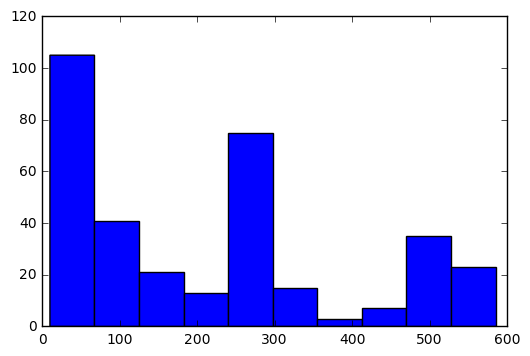

In [20]:
plt.hist(trimmed_df['job'].value_counts())

In [27]:
clean_job_posts = trimmed_df.drop_duplicates(subset=['desc']).reset_index()

In [30]:
clean_job_posts

,index,_id,company,desc,job,job_url,source,title,less_10
0,0,58bf5d948a68181df89793f9,NaN,\n\n\n\n\nThis article needs additional citati...,/wiki/Creative_director,NaN,wiki,NaN,False
1,1,58bf5d948a68181df89793fa,NaN,\n\n\n\n\nThis article does not cite any sourc...,/wiki/Software_analyst,NaN,wiki,NaN,False
2,2,58bf5d948a68181df89793fb,NaN,Web design encompasses many different skills a...,/wiki/Web_designer,NaN,wiki,NaN,False
3,3,58bf5d958a68181df89793fc,NaN,This article is about the profession. For othe...,/wiki/Scientist,NaN,wiki,NaN,False
4,7,58bf5d958a68181df8979400,NaN,\n\n\n\n\n\nThis article has multiple issues. ...,/wiki/Arts_administration,NaN,wiki,NaN,False
5,8,58bf5d968a68181df8979401,NaN,A theatre consultant is a consultant who speci...,/wiki/Theatre_consultant,NaN,wiki,NaN,False
6,9,58bf5d968a68181df8979402,NaN,This article is about theatre carpenters. For ...,/wiki/Carpenter_(theater),NaN,wiki,NaN,False
7,11,58bf5d968a68181df8979404,NaN,"""Clinical laboratory"" redirects here. For the ...",/wiki/Medical_Laboratory_Technician,NaN,wiki,NaN,False
8,13,58bf5d978a68181df8979406,NaN,\n\n\n\n\n\nThis article has multiple issues. ...,/wiki/Chief_visibility_officer,NaN,wiki,NaN,False
9,14,58bf5d978a68181df8979407,NaN,\nUrban Planner\n\nOccupation\n\n\nNames\ncity...,/wiki/Urban_planner,NaN,wiki,NaN,False


In [36]:
pickle.dump(clean_job_posts[['index', '_id', 'company', 'job_url', 'title', 'desc', 'job', 'source']], open("jobposts2.p", "wb" ))